# 1- Importing libraries

In [38]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import string
import re
import os
import nltk
from nltk.corpus import stopwords, twitter_samples
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt 


print("Version: ", tf.__version__)

Version:  2.16.1


# 2- Loading and Preprocessing data

In [2]:
# imdb_data_path = "../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

In [24]:
imdb_data = pd.read_csv("IMDB Dataset.csv")

In [25]:
# Converting the positive labels to 1 and the negative labels to 0

imdb_data['sentiment'].mask(imdb_data['sentiment'] == 'positive', 1, inplace=True)
imdb_data['sentiment'].mask(imdb_data['sentiment'] == 'negative', 0, inplace=True)

In [26]:
# Get the reviews and the labels

all_reviews = list(imdb_data['review'])
labels = np.asarray(imdb_data['sentiment'])

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# cutoff reviews after 200 words
maxlen = 200
training_samples = 40000
validation_samples = 5000
testing_samples = 5000

# consider the top 100000 words in the dataset
max_words = 100000

# tokenize each review in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(all_reviews)
sequences = tokenizer.texts_to_sequences(all_reviews)

In [28]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 124252 unique tokens.


In [29]:
# pad the sequences so that all sequences are of the same size
data = pad_sequences(sequences, maxlen=maxlen)

In [31]:
# shuffling the data and labels

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# Splitting the data set to training and validation datasets 

x_train = data[: training_samples]
y_train = labels[: training_samples]

x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

x_test = data[training_samples + validation_samples: training_samples + validation_samples + testing_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + testing_samples]

# x_train = np.asarray(x_train).astype(np.int)
# y_train = np.asarray(y_train).astype(np.int)
# x_val = np.asarray(x_val).astype(np.int)
# y_val = np.asarray(y_val).astype(np.int)
# x_test = np.asarray(x_test).astype(np.int)
# y_test = np.asarray(y_test).astype(np.int)
x_train = np.asarray(x_train).astype(int)
y_train = np.asarray(y_train).astype(int)
x_val = np.asarray(x_val).astype(int)
y_val = np.asarray(y_val).astype(int)
x_test = np.asarray(x_test).astype(int)
y_test = np.asarray(y_test).astype(int)


In [32]:
x_train.shape

(40000, 200)

In [33]:
x_val.shape

(5000, 200)

In [34]:
x_test.shape

(5000, 200)

# 3- Deep Learning Models

## 3.1- Simple Model 

In [39]:
# embedding_dim = 300
# simple_model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
#     #tf.keras.layers.Flatten(),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# simple_model.compile(loss='binary_crossentropy',
#                      optimizer='adam',
#                      metrics=['accuracy'])

# simple_model_history = simple_model.fit(x_train,y_train,
#                                         validation_data=(x_val,y_val),
#                                         epochs=5)

embedding_dim = 300
simple_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

simple_model.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

simple_model_history = simple_model.fit(x_train, y_train,
                                        validation_data=(x_val, y_val),
                                        epochs=5,
                                        batch_size=32)  # You may want to specify batch_size



Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 284s 225ms/step - accuracy: 0.7601 - loss: 0.4597 - val_accuracy: 0.8344 - val_loss: 0.4023
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 284s 227ms/step - accuracy: 0.9231 - loss: 0.1969 - val_accuracy: 0.8906 - val_loss: 0.2838
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 278s 222ms/step - accuracy: 0.9465 - loss: 0.1429 - val_accuracy: 0.8910 - val_loss: 0.3526
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 276s 221ms/step - accuracy: 0.9628 - loss: 0.1013 - val_accuracy: 0.8484 - val_loss: 0.5054
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 276s 221ms/step - accuracy: 0.9672 - loss: 0.0864 - val_accuracy: 0.8548 - val_loss: 0.5128


# 4- Models Performance visualization

In [40]:
def plot_acc_and_loss(model_histpry):

    acc = model_histpry.history['accuracy']
    val_acc = model_histpry.history['val_accuracy']

    loss = model_histpry.history['loss']
    val_loss = model_histpry.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 4), dpi=80)

    ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
    ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
    ax[0].grid(alpha=0.3)
    ax[0].title.set_text('Training Vs Validation Accuracy')
    ax[0].fill_between(epochs, acc, val_acc, color='crimson', alpha=0.3)
    plt.setp(ax[0], xlabel='Epochs')
    plt.setp(ax[0], ylabel='Accuracy')


    ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
    ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
    ax[1].grid(alpha=0.3)
    ax[1].title.set_text('Training Vs Validation Loss')
    ax[1].fill_between(epochs,loss, val_loss, color='crimson', alpha=0.3)
    plt.setp(ax[1], xlabel='Epochs')
    plt.setp(ax[1], ylabel='Loss')

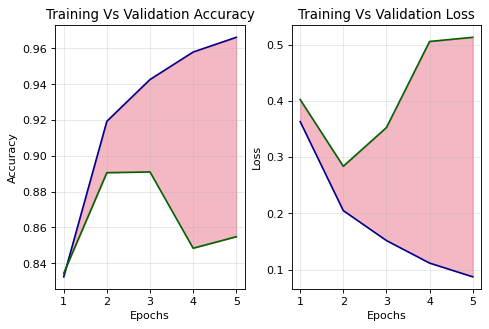

In [41]:
plot_acc_and_loss(simple_model_history)

# 5- Testing and Prediction

In [42]:
def eval_model(model):
    
    model_acc_train_dataset = model.evaluate(x_train, y_train)
    model_acc_val_dataset = model.evaluate(x_val, y_val)
    model_acc_test_dataset = model.evaluate(x_test, y_test)
    
    return model_acc_train_dataset, model_acc_val_dataset, model_acc_test_dataset

simple_model_acc_train_dataset, simple_model_acc_val_dataset, simple_model_acc_test_dataset = eval_model(simple_model)
#simple_rnn_model_acc_train_dataset, simple_rnn_model_acc_val_dataset, simple_rnn_model_acc_test_dataset = eval_model(simple_rnn_model)


train_accs = [simple_model_acc_train_dataset[1]]

val_accs = [simple_model_acc_val_dataset[1]]

test_accs = [simple_model_acc_test_dataset[1]]

models_eval_df = pd.DataFrame({"Training Accuracy":train_accs, "Validation Accuracy":val_accs, "Testing Accuracy":test_accs},
                              index=['simple_model'])

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.9645 - loss: 0.0802
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.8587 - loss: 0.5119
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8580 - loss: 0.5353


In [43]:
models_eval_df

,Training Accuracy,Validation Accuracy,Testing Accuracy
simple_model,0.96485,0.8548,0.8596


In [44]:
class_names = ["Positive","Negative"]

In [54]:
y_predict = simple_model.predict(x_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [55]:
y_predict=y_predict.astype(int)

In [56]:
 from sklearn.metrics import classification_report, confusion_matrix

In [57]:
print(classification_report(y_test, y_predict, target_names=class_names))

print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

    Positive       0.51      1.00      0.68      2543
    Negative       1.00      0.01      0.02      2457

    accuracy                           0.51      5000
   macro avg       0.76      0.50      0.35      5000
weighted avg       0.75      0.51      0.35      5000

[[2543    0]
 [2434   23]]
